## EDA to see the labels

## To do lists : remove uncertained and unlabeled

In [1]:
import os
import pandas as pd

# Set directory path
csv_directory = "/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train"

# Collect unique label values
unique_labels = set()

# Iterate through all CSV files in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        csv_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(csv_path)

        # Assuming labels are stored in a column named "label"
        if "labels" in df.columns:
            unique_labels.update(df["labels"].unique())

# Print unique label values
print("Unique Labels Found:")
print(unique_labels)

Unique Labels Found:
{'Unlabeled', 'Narrow+Broad', 'Broad+Pulse', 'Narrow+Pulse', nan, 'Broad', 'Uncertain', 'Pulse', nan, 'Unknown+Pulse', 'Narrow'}


In [5]:
import numpy as np
import pandas as pd
import glob
import os
from torch.utils.data import Dataset, DataLoader

# Set the path for Input Spectra and Label
dataset_dir = "/kaggle/input/signal-fast-radio-burst-detection/train/train" 
dataset_label_dir = "/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train"
X_Training_Files = sorted(glob.glob(os.path.join(dataset_dir, "*.npy")))
Y_Training_Files = sorted(glob.glob(os.path.join(dataset_label_dir, "*.csv")))

In [6]:
# Let's Inspect Something by pick up the data for inspection
rec_num = 0
X_demo = np.load(X_Training_Files[rec_num])
Y_demo = pd.read_csv(Y_Training_Files[rec_num])
Y_demo["labels"].value_counts()

labels
Broad          80
Pulse           9
Broad+Pulse     2
Name: count, dtype: int64

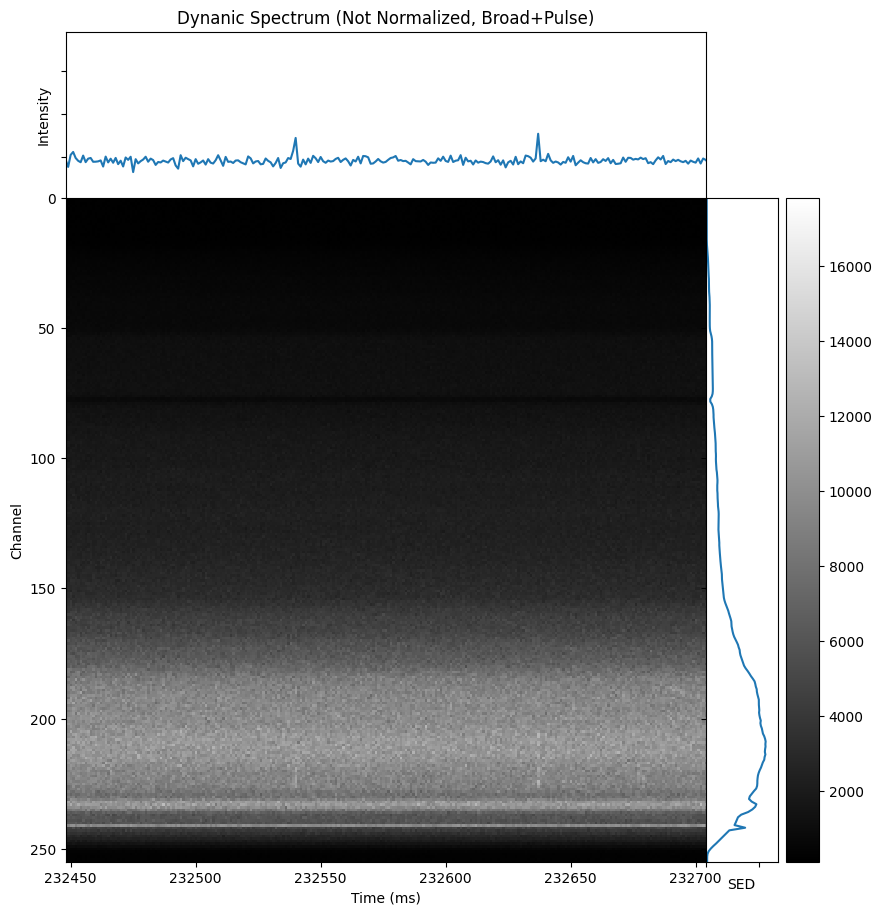

In [7]:
import matplotlib.pyplot as plt

def make_plot(X_demo, title_string=None, peak = None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.93,
                            wspace=0, hspace=0)

    dynanic_spectrum = np.transpose(X_demo) # แกนเวลากับ Channel สลับกัน

    ax1 = fig.add_subplot(gs[1, 0])
    heatmap = ax1.imshow(dynanic_spectrum,aspect="auto", origin='upper', interpolation="none", cmap="gray",vmin=vmin,vmax=vmax)
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Channel")
    ax1.set_ylim(dynanic_spectrum.shape[0]-1,0)

    if peak is not False:
        if peak is None:
            peak = np.argmax(np.sum(dynanic_spectrum,axis=0))
        else:
            peak = peak * 256
        offset = 256
        ax1.set_xlim(peak, peak+offset)

    ax2 = fig.add_subplot(gs[1, 1])
    powerspectrum = np.sum(dynanic_spectrum,axis=1)
    freq_bin = np.linspace(0,len(powerspectrum),len(powerspectrum))
    plt.plot(powerspectrum, freq_bin)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_xlim(0, 1.2 * np.max(powerspectrum))
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel("SED")


    ax3 = fig.add_subplot(gs[0, 0])
    lightcurve = np.sum(dynanic_spectrum,axis=0)
    ax3.plot(lightcurve)
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    #ax3.set_ylim(0, 1.2 * np.max(lightcurve))
    ax3.set_ylabel(r"Intensity")
    if title_string is not None:
        ax3.set_title(title_string)

    fig.colorbar(heatmap, ax=ax2, orientation="vertical",fraction = .5)
    plt.show()

make_plot(X_demo, title_string="Dynanic Spectrum (Not Normalized, Broad+Pulse)", peak=908)

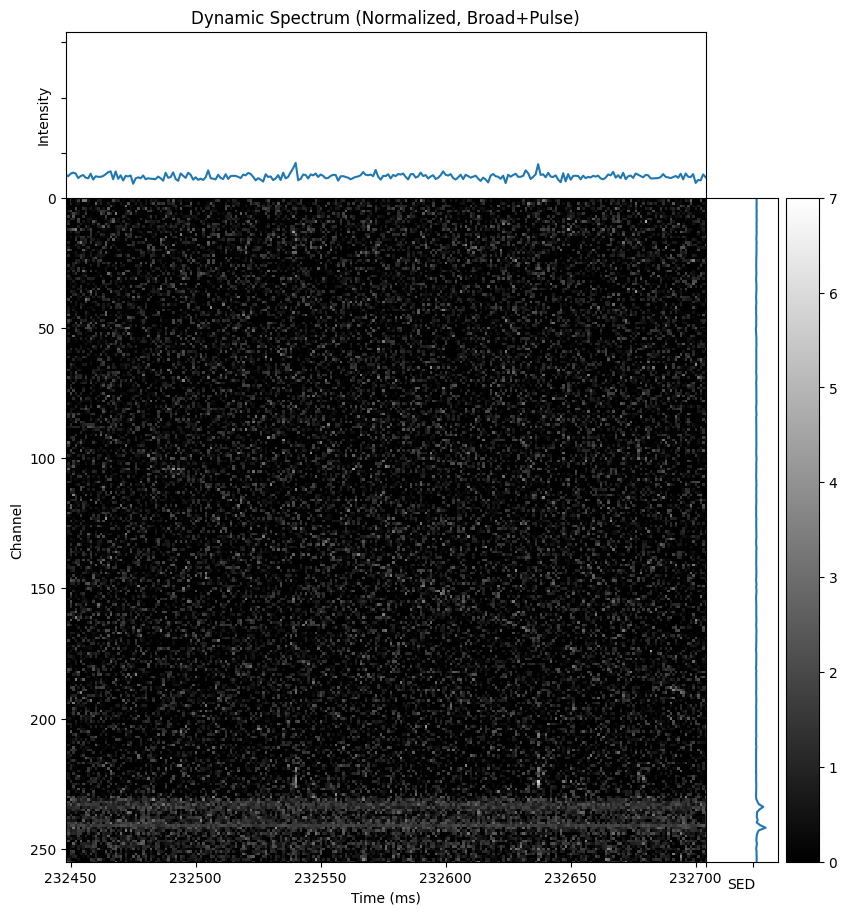

In [8]:
def snr_normalized(X_demo):
    Dynamic_spectrum = np.transpose(X_demo)
    med = np.median(Dynamic_spectrum, axis=1)
    stdev = np.std(Dynamic_spectrum, axis=1)
    normalized_Dynamic_spectrum = (Dynamic_spectrum.T - med) / stdev
    normalized_Dynamic_spectrum[normalized_Dynamic_spectrum < 0] = 0
    return normalized_Dynamic_spectrum

normalized_Dynamic_spectrum = snr_normalized(X_demo)

make_plot(normalized_Dynamic_spectrum, title_string="Dynamic Spectrum (Normalized, Broad+Pulse)",peak=908,vmin=0, vmax=7)

In [9]:
pd.set_option('future.no_silent_downcasting', True)

## Multi-Input Labels Encoding (Mapping)

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# 'Narrow+Broad', 'Narrow+Pulse', 
# 'Pulse', 'Unknown+Pulse', nan, 'Broad+Pulse', 
# 'Unlabeled', 'Uncertain', 'Narrow', nan, 'Broad'

# Function to map labels to multi-label format
def map_labels(label):
    label_mapping = {
        "None": [0, 0, 0],
        "Unlabeled": [0, 0, 0],
        "Uncertain": [0, 0, 0],
        "Pulse": [1, 0, 0],
        "Broad": [0, 1, 0],
        "Narrow": [0, 0, 1],
        "Broad+Pulse": [1, 1, 0],
        "Narrow+Pulse": [1, 0, 1],
        "Narrow+Broad": [0, 1, 1],
        "Pulse+Broad+Narrow": [1, 1, 1]
    }
    return label_mapping.get(label, [0, 0, 0])  # Default to [0, 0, 0] if label is not found

# Load target files and replace labels with multi-label format
Label = []
pop_list = []
for i in tqdm(range(len(Y_Training_Files))):
    rec = pd.read_csv(Y_Training_Files[i])
    if len(rec) == 1024:
        labels = np.array([map_labels(label) for label in rec["labels"]])
        Label.append(labels)
    else:
        pop_list.append(i)

Label = np.array(Label, dtype=np.int32)

100%|██████████| 100/100 [00:00<00:00, 247.12it/s]


In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def find_all_uncertain_and_unlabeled(file_list):
    fully_uncertain_files = []
    fully_unlabeled_files = []
    
    for i in tqdm(range(len(file_list))):
        try:
            rec = pd.read_csv(file_list[i])
            # Get unique labels in the file, dropping any NaN values
            unique_labels = rec['labels'].dropna().unique()
            
            # Check if all non-NaN labels are Uncertain or Unlabeled
            if len(unique_labels) == 1:
                if unique_labels[0] == 'Uncertain':
                    fully_uncertain_files.append({
                        'index': i,
                        'file': file_list[i],
                        'rows': len(rec)
                    })
                elif unique_labels[0] == 'Unlabeled':
                    fully_unlabeled_files.append({
                        'index': i,
                        'file': file_list[i],
                        'rows': len(rec)
                    })
        except Exception as e:
            print(f"Error processing file {file_list[i]}: {str(e)}")
    
    return fully_uncertain_files, fully_unlabeled_files

# Find files that are completely Uncertain or Unlabeled
uncertain_files, unlabeled_files = find_all_uncertain_and_unlabeled(Y_Training_Files)

# Print results for Uncertain files
print("\nFiles with all indexes marked as Uncertain:")
print("-------------------------------------------")
for file_info in uncertain_files:
    print(f"Index: {file_info['index']}")
    print(f"File: {file_info['file']}")
    print(f"Number of rows: {file_info['rows']}")
    print("-------------------------------------------")
print(f"Total Uncertain files found: {len(uncertain_files)}")

# Print results for Unlabeled files
print("\nFiles with all indexes marked as Unlabeled:")
print("-------------------------------------------")
for file_info in unlabeled_files:
    print(f"Index: {file_info['index']}")
    print(f"File: {file_info['file']}")
    print(f"Number of rows: {file_info['rows']}")
    print("-------------------------------------------")
print(f"Total Unlabeled files found: {len(unlabeled_files)}")

100%|██████████| 100/100 [00:00<00:00, 471.75it/s]


Files with all indexes marked as Uncertain:
-------------------------------------------
Index: 44
File: /kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/B0531+21_58713_43190_reduced_fc_0023551_labels.csv
Number of rows: 1024
-------------------------------------------
Total Uncertain files found: 1

Files with all indexes marked as Unlabeled:
-------------------------------------------
Index: 96
File: /kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/J2145-0750_59475_75870_reduced_fc_0001023_labels.csv
Number of rows: 1024
-------------------------------------------
Index: 97
File: /kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/J2145-0750_59475_75870_reduced_fc_0002047_labels.csv
Number of rows: 1024
-------------------------------------------
Index: 98
File: /kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/J2145-0750_59475_75870_reduced_fc_0003071_labels.csv
Number of rows

In [12]:
import numpy as np
from collections import Counter

# Label mapping
label_mapping = {
        "None": [0, 0, 0],
        "Pulse": [1, 0, 0],
        "Broad": [0, 1, 0],
        "Narrow": [0, 0, 1],
        "Broad+Pulse": [1, 1, 0],
        "Narrow+Pulse": [1, 0, 1],
        "Narrow+Broad": [0, 1, 1],
        "Pulse+Broad+Narrow": [1, 1, 1]
}

# Initialize a counter for all labels
total_count = Counter()

# Convert to list of tuples and count occurrences for each array
for current_label in Label:
    tuples = [tuple(row) for row in current_label]
    count = Counter(tuples)
    total_count.update(count)

# Print the total counts for each combination in label_mapping
for label, combo in label_mapping.items():
    print(f"Total count for {label} ({combo}): {total_count[tuple(combo)]}")

Total count for None ([0, 0, 0]): 76266
Total count for Pulse ([1, 0, 0]): 3502
Total count for Broad ([0, 1, 0]): 3001
Total count for Narrow ([0, 0, 1]): 8162
Total count for Broad+Pulse ([1, 1, 0]): 9
Total count for Narrow+Pulse ([1, 0, 1]): 58
Total count for Narrow+Broad ([0, 1, 1]): 138
Total count for Pulse+Broad+Narrow ([1, 1, 1]): 0


In [ ]:
# Here, we partitioned each dynamic spectrum to small chunks of images and treated it that way.
X_Training_Files_popped = np.delete(X_Training_Files.copy(),pop_list)
Input = np.empty(shape=(len(X_Training_Files_popped),
                        normalized_Dynamic_spectrum.shape[0]//normalized_Dynamic_spectrum.shape[1],
                        normalized_Dynamic_spectrum.shape[1],
                        normalized_Dynamic_spectrum.shape[1]),dtype=np.float32)

for i in tqdm(range(0,len(X_Training_Files_popped))):
    img = np.load(X_Training_Files_popped[i])
    img = snr_normalized(img) # normalized
    img = img.T
    for j in range(0,img.shape[1]//img.shape[0]): # 256 channel
        loc = int(img.shape[0] * j)
        Input[i,j] = img[:,loc:loc+img.shape[0]]

Input = Input.reshape(Input.shape[0]*Input.shape[1],Input.shape[2],Input.shape[3])

 90%|████████▉ | 80/89 [07:50<00:58,  6.50s/it]

## Save input_array

In [ ]:
Input.shape

In [17]:
Label.shape

(89, 1024, 3)

In [18]:
import torch
import numpy as np

batch_size_train = 32

# Transform the Numpy arrays to Torch tensor and ensure 3 channels
Input_tensor = torch.from_numpy(Input).reshape(Input.shape[0], 1, Input.shape[1], Input.shape[2])  # Input
#Input_tensor = Input_tensor.repeat(1, 3, 1, 1)  # Repeat channels to have 3 channels

# Ensure Target tensor matches multi-label setup
Target_tensor = torch.from_numpy(Label).reshape(-1, Label.shape[2])  # Multi-label Target

# Make the loader + batch_size for the convenience
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Input_tensor, Target_tensor),
    batch_size=batch_size_train, shuffle=True)

train_losses = []

# Example of printing the shape to verify correctness
print(f'Input Tensor Shape: {Input_tensor.shape}')
print(f'Target Tensor Shape: {Target_tensor.shape}')

Input Tensor Shape: torch.Size([91136, 1, 256, 256])
Target Tensor Shape: torch.Size([91136, 3])


In [19]:
pip install efficientnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusted padding to 1

    def extract(self, x):
        return self.enet(x)
      
    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        
        return torch.sigmoid(x)  # Apply sigmoid for multi-label classification


# Example usage
batch_size_train = 32

# Transform the Numpy arrays to Torch tensor and ensure 3 channels
Input_tensor = torch.from_numpy(Input).reshape(Input.shape[0], 1, Input.shape[1], Input.shape[2])  # Input
Input_tensor = Input_tensor.repeat(1, 3, 1, 1)  # Repeat channels to have 3 channels

# Ensure Target tensor matches multi-label setup
Target_tensor = torch.from_numpy(Label).reshape(-1, Label.shape[2])  # Multi-label Target

# Make the loader + batch_size for convenience
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Input_tensor, Target_tensor),
    batch_size=batch_size_train, shuffle=True)

# Initialize the model
model = enetv2('efficientnet-b6', 3)  # Assuming 3 output classes

# Example training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [55]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [60]:
import torch
torch.cuda.empty_cache()

## Way 2 : Balanced Signal CNN

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
import numpy as np
from scipy import signal

In [24]:
class WeightedBCELoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedBCELoss, self).__init__()
        self.class_weights = torch.tensor(class_weights).cuda()
    
    def forward(self, pred, target):
        # Weight the BCE loss for each class
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        weighted_bce = bce * self.class_weights.expand_as(bce)
        return weighted_bce.mean()

In [25]:
class BalancedSignalCNN(nn.Module):
    def __init__(self):
        super(BalancedSignalCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Attention mechanism for focusing on weak signals
        self.attention = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)  # Increased dropout for better generalization
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Apply attention
        attention_weights = self.attention(x)
        x = x * attention_weights
        
        x = x.view(-1, 128 * 32 * 32)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.sigmoid(x)

In [26]:
def create_balanced_sampler(labels):
    class_counts = torch.sum(labels, dim=0)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()
    
    sample_weights = torch.zeros(len(labels))
    for i, label in enumerate(labels):
        sample_weights[i] = class_weights[label.bool()].sum()
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(labels),
        replacement=True
    )
    return sampler

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Correct import
import numpy as np
from torch.utils.data import WeightedRandomSampler

def train_model(model, train_loader, num_epochs=1, device='cuda'):
    model = model.to(device)
    
    total_samples = 91136
    class_weights = [
        3002/total_samples,    # Pulse
        3001/total_samples,    # Broad
        3003/total_samples     # Narrow
    ]
    class_weights = [1/w for w in class_weights]
    class_weights = [w/sum(class_weights) for w in class_weights]
    
    criterion = WeightedBCELoss(class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        scheduler.step(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}')
        
    return model

In [28]:
# Create balanced sampler
sampler = create_balanced_sampler(Target_tensor)

# Create balanced dataloader
balanced_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Input_tensor, Target_tensor),
    batch_size=32,
    sampler=sampler
)

# Create and train model
model = BalancedSignalCNN()
trained_model = train_model(model, balanced_loader)

Epoch 1, Batch 0, Loss: 0.2326
Epoch 1, Batch 100, Loss: 15.6236
Epoch 1, Batch 200, Loss: 13.8883
Epoch 1, Batch 300, Loss: 14.9296
Epoch 1, Batch 400, Loss: 14.5819
Epoch 1, Batch 500, Loss: 14.9297
Epoch 1, Batch 600, Loss: 11.4578
Epoch 1, Batch 700, Loss: 17.7074
Epoch 1, Batch 800, Loss: 13.5409
Epoch 1, Batch 900, Loss: 14.5825
Epoch 1, Batch 1000, Loss: 12.8460
Epoch 1, Batch 1100, Loss: 16.3184
Epoch 1, Batch 1200, Loss: 14.9296
Epoch 1, Batch 1300, Loss: 18.0539
Epoch 1, Batch 1400, Loss: 13.1938
Epoch 1, Batch 1500, Loss: 15.6237
Epoch 1, Batch 1600, Loss: 11.4573
Epoch 1, Batch 1700, Loss: 16.6656
Epoch 1, Batch 1800, Loss: 15.9708
Epoch 1, Batch 1900, Loss: 15.6240
Epoch 1, Batch 2000, Loss: 12.1517
Epoch 1, Batch 2100, Loss: 14.5818
Epoch 1, Batch 2200, Loss: 19.0960
Epoch 1, Batch 2300, Loss: 14.5823
Epoch 1, Batch 2400, Loss: 15.2763
Epoch 1, Batch 2500, Loss: 12.1515
Epoch 1, Batch 2600, Loss: 18.0538
Epoch 1, Batch 2700, Loss: 13.5411
Epoch 1, Batch 2800, Loss: 15.971

In [29]:
# Save the model
torch.save(model.state_dict(), 'new_balanced_cnn_4.pth')

---

In [38]:
import torch
import numpy as np
import os
import glob
from tqdm import tqdm
import pandas as pd

def snr_normalized(dynamic_spectrum):
    """
    SNR normalization as used in training
    """
    mean = np.mean(dynamic_spectrum)
    std = np.std(dynamic_spectrum)
    return (dynamic_spectrum - mean) / std

def predict_test_folder(model, test_folder, device='cuda', batch_size=32):
    """
    Process test folder and create predictions in required CSV format with padding for irregular sizes
    """
    test_files = sorted(glob.glob(os.path.join(test_folder, "*.npy")))
    all_ids = []
    all_predictions = []
    
    model.eval()
    
    for file_path in tqdm(test_files, desc="Processing test files"):
        file_name = os.path.basename(file_path).split('.')[0]
        print(file_name)
        
        # Load and preprocess the file
        img = np.load(file_path)
        img = snr_normalized(img)
        img = img.T
        
        # Calculate padding if needed
        chunk_size = 256
        width = img.shape[1]
        if width % chunk_size != 0:
            padding_needed = chunk_size - (width % chunk_size)
            # Pad with zeros on the right side
            img = np.pad(img, ((0, 0), (0, padding_needed)), mode='constant', constant_values=0)
        
        # Cut into chunks of 256x256
        num_chunks = img.shape[1] // chunk_size
        chunks = []
        chunk_ids = []
        
        for j in range(num_chunks):
            start_idx = j * chunk_size
            end_idx = start_idx + chunk_size
            chunk = img[:, start_idx:end_idx]
            chunks.append(chunk)
            chunk_ids.append(f"{file_name}_{j}")
        
        if not chunks:  # Handle case where image is smaller than chunk_size
            chunks = [np.pad(img, ((0, 0), (0, chunk_size - img.shape[1])), 
                           mode='constant', constant_values=0)]
            chunk_ids = [f"{file_name}_0"]
        
        # Convert chunks to tensor
        chunks_tensor = torch.from_numpy(np.array(chunks)).float().unsqueeze(1)
        
        # Process chunks in batches
        predictions = []
        with torch.no_grad():
            for i in range(0, len(chunks_tensor), batch_size):
                batch = chunks_tensor[i:i + batch_size].to(device)
                outputs = model(batch)
                predictions.append(outputs.cpu().numpy())
        
        file_predictions = np.vstack(predictions)
        all_ids.extend(chunk_ids)
        all_predictions.append(file_predictions)
        print(file_predictions)
    
    final_predictions = np.vstack(all_predictions)
    binary_predictions = (final_predictions > 0.6).astype(int)
    
    df = pd.DataFrame({
        'id': all_ids,
        'pulse': binary_predictions[:, 0],
        'broad': binary_predictions[:, 1],
        'narrow': binary_predictions[:, 2]
    })
    
    return df

# Configuration
test_folder = "/kaggle/input/signal-fast-radio-burst-detection/test/test"
model_path = "new_balanced_cnn_1.pth"
submission_path = "day2_4_submission.csv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load model
# model = BalancedSignalCNN()  # Your model class
# model.load_state_dict(torch.load(model_path))
# model = model.to(device)

# Make predictions and create submission file
submission_df = predict_test_folder(model, test_folder, device)

# Save submission file
submission_df.to_csv(submission_path, index=False)

# Print first few rows to verify format
print("\nFirst few rows of submission file:")
print(submission_df.head())

# Print summary
print("\nSubmission Summary:")
print(f"Total predictions: {len(submission_df)}")
print("\nPredictions per class:")
print(f"Pulse: {submission_df['pulse'].sum()}")
print(f"Broad: {submission_df['broad'].sum()}")
print(f"Narrow: {submission_df['narrow'].sum()}")

Processing test files:   0%|          | 0/33 [00:00<?, ?it/s]

0


Processing test files:   3%|▎         | 1/33 [00:01<00:45,  1.41s/it]

[[0.46013737 0.00127143 0.7649759 ]
 [0.47321507 0.00125653 0.76362616]
 [0.47279385 0.00121405 0.76510906]
 ...
 [0.46797463 0.00121708 0.7692765 ]
 [0.4606399  0.00123604 0.7765895 ]
 [0.47159132 0.00126453 0.76236904]]
1


Processing test files:   6%|▌         | 2/33 [00:05<01:39,  3.19s/it]

[[0.4651124  0.00119149 0.77726066]
 [0.4635127  0.00116943 0.7768398 ]
 [0.48154786 0.00125505 0.76308906]
 ...
 [0.463103   0.00117413 0.77933633]
 [0.4731015  0.00117782 0.7726207 ]
 [0.4856289  0.00122294 0.762991  ]]
10


Processing test files:   9%|▉         | 3/33 [00:08<01:28,  2.95s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
11


Processing test files:  12%|█▏        | 4/33 [00:11<01:24,  2.91s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
12


Processing test files:  15%|█▌        | 5/33 [00:14<01:19,  2.83s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48385167 0.51410556 0.4475403 ]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
13


Processing test files:  18%|█▊        | 6/33 [00:16<01:15,  2.78s/it]

[[0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
14


Processing test files:  21%|██        | 7/33 [00:19<01:11,  2.73s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
15


Processing test files:  24%|██▍       | 8/33 [00:22<01:08,  2.74s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
16


Processing test files:  27%|██▋       | 9/33 [00:24<01:06,  2.77s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
17


Processing test files:  30%|███       | 10/33 [00:27<01:04,  2.79s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
18


Processing test files:  33%|███▎      | 11/33 [00:30<01:01,  2.81s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
19


Processing test files:  36%|███▋      | 12/33 [00:33<00:58,  2.78s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
2


Processing test files:  39%|███▉      | 13/33 [00:34<00:46,  2.33s/it]

[[0.46991402 0.00121007 0.7767707 ]
 [0.4780242  0.00119024 0.7697053 ]
 [0.47455412 0.00116206 0.7735771 ]
 ...
 [0.479112   0.00121114 0.76800317]
 [0.45641857 0.00123667 0.77206624]
 [0.47722784 0.00121759 0.7663    ]]
20


Processing test files:  42%|████▏     | 14/33 [00:37<00:46,  2.46s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
21


Processing test files:  45%|████▌     | 15/33 [00:40<00:45,  2.53s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]]
22


Processing test files:  48%|████▊     | 16/33 [00:42<00:43,  2.59s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48381412 0.5141971  0.44748503]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
23


Processing test files:  55%|█████▍    | 18/33 [00:45<00:28,  1.87s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
24
[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.5141

Processing test files:  58%|█████▊    | 19/33 [00:48<00:28,  2.06s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.48385307 0.51410335 0.4475411 ]
 [0.4683852  0.5450838  0.42781764]]
26


Processing test files:  61%|██████    | 20/33 [00:49<00:23,  1.83s/it]

[[0.48390934 0.51409125 0.44751358]
 [0.4864484  0.5130677  0.44693437]
 [0.4864062  0.511144   0.447075  ]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
27


Processing test files:  64%|██████▎   | 21/33 [00:50<00:19,  1.65s/it]

[[0.9981627  0.00169585 0.09625006]
 [0.99282575 0.03698425 0.08239477]
 [0.8427951  0.17397426 0.3016332 ]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
28


Processing test files:  67%|██████▋   | 22/33 [00:51<00:16,  1.54s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.48385257 0.5141041  0.4475406 ]
 [0.3426773  0.39038047 0.52629507]]
29


Processing test files:  70%|██████▉   | 23/33 [00:53<00:14,  1.46s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838293  0.51413184 0.44752842]
 [0.4838532  0.51410306 0.44754136]
 [0.4504756  0.51957256 0.45564735]]
3


Processing test files:  73%|███████▎  | 24/33 [00:55<00:16,  1.80s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838529  0.5141035  0.44754112]
 [0.4838532  0.51410306 0.44754136]]
30


Processing test files:  76%|███████▌  | 25/33 [00:56<00:10,  1.36s/it]

[[0.48385313 0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44

Processing test files:  79%|███████▉  | 26/33 [00:57<00:09,  1.33s/it]

[[0.4837098  0.5139583  0.4476317 ]
 [0.48401874 0.5138617  0.44758865]
 [0.48393586 0.51399344 0.44757068]
 ...
 [0.5026527  0.46790347 0.44878036]
 [0.48385054 0.51405144 0.44759056]
 [0.51226264 0.41610596 0.45891458]]
32


Processing test files:  82%|████████▏ | 27/33 [00:58<00:07,  1.23s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
4


Processing test files:  85%|████████▍ | 28/33 [01:01<00:08,  1.65s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
5


Processing test files:  88%|████████▊ | 29/33 [01:03<00:07,  1.99s/it]

[[0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.5141031  0.44754133]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.5141031  0.44754127]]
6


Processing test files:  91%|█████████ | 30/33 [01:06<00:06,  2.17s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
7


Processing test files:  94%|█████████▍| 31/33 [01:08<00:04,  2.28s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.48385313 0.51410306 0.44754133]
 [0.4838532  0.51410306 0.44754136]]
8


Processing test files:  97%|█████████▋| 32/33 [01:11<00:02,  2.37s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]
9


Processing test files: 100%|██████████| 33/33 [01:14<00:00,  2.25s/it]

[[0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.48385268 0.51410383 0.4475411 ]
 ...
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]
 [0.4838532  0.51410306 0.44754136]]

First few rows of submission file:
    id  pulse  broad  narrow
0  0_0      0      0       1
1  0_1      0      0       1
2  0_2      0      0       1
3  0_3      0      0       1
4  0_4      0      0       1

Submission Summary:
Total predictions: 28108

Predictions per class:
Pulse: 167
Broad: 15
Narrow: 2511
